100%|██████████| 100/100 [00:04<00:00, 22.09it/s]


Test Accuracy: 86.62%


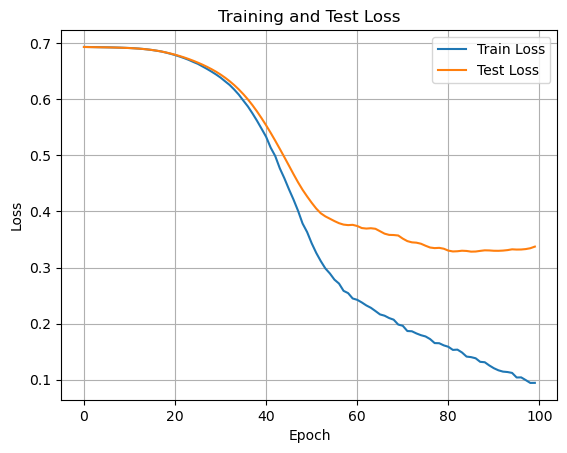

In [1]:
filename_1 = "C:/insert local pathDemocrattweets_combined_clean.csv"
filename_2 = "C:/insert local path/Repub_tweets_combined_clean.csv"
import re
import numpy as np
import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

def tweet_list(filename): # Mainly written by myself, but with assistance from ChatGPT:
    with open(filename, mode='r', encoding='utf-8') as f:
        reader = f.read() 
    tweets = reader.strip().split('\n')
    tweets = [tweet.strip() for tweet in tweets if tweet.strip()]
    tweets = [re.sub(r'\d+', '', tweet) for tweet in tweets]
    return (tweets)
    
tweets_list_D = tweet_list(filename_1)
tweets_list_R = tweet_list(filename_2)
full_tweet_list = tweets_list_D[:4400]+tweets_list_R[:4400]

def random_testdata(tweetlist):
    x = round(0.2 * len(tweetlist))
    test_data = []
    training_data = tweetlist.copy()
    for _ in range(x):
        chosen_element = random.choice(training_data)  
        test_data.append(chosen_element) 
        training_data.remove(chosen_element)   
    return test_data, training_data
 
test_data_R,training_data_R = random_testdata(tweets_list_R)
test_data_D, training_data_D = random_testdata(tweets_list_D)

min_size = min(len(training_data_D), len(training_data_R))

training_data_D_equal = training_data_D[:min_size]
training_data_R_equal = training_data_R[:min_size]

min_size = min(len(test_data_D), len(test_data_R))

test_data_D_equal = test_data_D[:min_size]
test_data_R_equal = test_data_R[:min_size]

full_trainingdata = np.concatenate([training_data_D_equal,training_data_R_equal])
len(full_trainingdata)
full_testdata = np.concatenate([test_data_D_equal,test_data_R_equal])

# With assistance from ChatGPT:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(full_trainingdata)
tfidf_matrix = tfidf_matrix.toarray()

# With assistance from ChatGPT:
svd_transformer = TruncatedSVD(n_components=300)
svd_matrix = svd_transformer.fit_transform(tfidf_matrix)

# Create y lists:
D = np.zeros(len(training_data_D_equal))
R = np.ones(len(training_data_R_equal))
y_train = np.concatenate([D, R])
len(y_train)

D = np.zeros(len(test_data_D_equal))
R = np.ones(len(test_data_R_equal))
y_test = np.concatenate([D, R])
import joblib

# Save the TF-IDF vectorizer and SVD transformer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(svd_transformer, "svd_transformer.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
svd_transformer = joblib.load("svd_transformer.pkl")

def preprocess_tweet(tweet,tfidf,SVD):
    tfidf_tweet = tfidf.transform(tweet)
    svd_tweet = SVD.transform(tfidf_tweet)
    return svd_tweet

# Help from TA, Jonathan.
# Guided by examples from class and example given by our teacher Mikkel.


# Device to use for computations
device = torch.device('cpu')

#%% Settings
weight_decay = 1e-5
learning_rate = 0.001
T = 100 # Number of epochs

def create_dataset(svd_matrix, y_liste):
    features = torch.tensor(svd_matrix, dtype=torch.float)
    labels = torch.tensor(y_liste, dtype=torch.float)
    return features, labels

x_train = svd_matrix.copy()

indices = torch.randperm(x_train.shape[0])  # Shuffle rows
x_train = x_train[indices]
y_train = y_train[indices]

x_test = preprocess_tweet(full_testdata,tfidf_vectorizer,svd_transformer)

indices = torch.randperm(x_test.shape[0])  # Shuffle rows - assistance from ChatGPT
x_test = x_test[indices]
y_test = y_test[indices]

x, y = create_dataset(x_train,y_train)
x_test, y_test = create_dataset(x_test,y_test)

model = torch.nn.Sequential(
    torch.nn.Linear(300, 240), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(240, 128), 
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64), 
    torch.nn.ReLU(),
    torch.nn.Linear(64, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
)
model.to(device)
x, y = x.to(device), y.to(device)

loss_fn = torch.nn.BCELoss() #Binary Crossentropy (R vs. D)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

train_loss = np.zeros(T)
test_loss = np.zeros(T)
best_loss = float('inf')

for t in tqdm(range(T)):
    model.train()
    y_pred = model(x).reshape(-1)

    loss = loss_fn(y_pred, y.reshape(-1))
    
    train_loss[t] = loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()    
    # Evaluation Phase
    model.eval()
    with torch.no_grad():
        y_pred_test = model(x_test)
        test_loss[t] = loss_fn(y_pred_test, y_test.unsqueeze(1)).item()

        # Save the best model
        if test_loss[t] < best_loss:
            best_loss = test_loss[t]
            torch.save(model.state_dict(), 'best_model.pth')

with torch.no_grad():
    y_pred_test = model(x_test)
    y_pred_labels = (y_pred_test > 0.5).float().reshape(-1) 
    accuracy = (y_pred_labels == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()

**Calculation of necessary sample size for the model with an error margin of 5% on a random politician, with an accuracy of 86,62%**

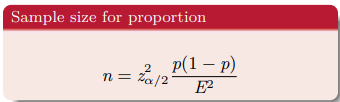

In [151]:
p = 1-0.8662
e = 0.05
n = 1.96**2 * (p*(1-p)/e**2)
n

178.09282659839997

Optimal sample size is therefore approximately 180 tweets. 

**Profiles of: Bernie Sanders og Ron DeSantis**

In [130]:
# Bernie Sanders (written partly with assistance from ChatGPT)

filename_3 = "C:/insert local path/TwExportly_BernieSanders_tweets_cleanP.csv"

jd_tweets = tweet_list(filename_3)
test_data_jd, training_data_jd = random_testdata(jd_tweets)

new_tweets = test_data_jd
model.eval()

predictions = []

for tweet in new_tweets:
    x_jdvance = preprocess_tweet([tweet.lower()], tfidf_vectorizer, svd_transformer)
    features = torch.tensor(x_jdvance, dtype=torch.float)
    
    with torch.no_grad():
        prediction = model(features)
        predictions.append(prediction.item())


average_predictionD = sum(predictions)/len(predictions)

# Determine predicted party
if average_predictionD > 0.5:
    classification = "Republican"
else:
    classification = "Democrat"

print(f"Average Prediction Value: {average_predictionD}")
print(f"Overall Classification: {classification}")

Average Prediction Value: 0.24648742018314915
Overall Classification: Democrat


In [131]:
# Ron DeSantis (written partly with assistance from ChatGPT)

filename_3 = "C:/insert local path/TwExportly_GovRonDeSantis_tweets_cleanP.csv"

jd_tweets = tweet_list(filename_3)
test_data_jd, training_data_jd = random_testdata(jd_tweets)

new_tweets = test_data_jd
model.eval()

predictions = []

for tweet in new_tweets:
    x_jdvance = preprocess_tweet([tweet.lower()], tfidf_vectorizer, svd_transformer)
    features = torch.tensor(x_jdvance, dtype=torch.float)
    
    with torch.no_grad():
        prediction = model(features)
        predictions.append(prediction.item())


average_predictionR = sum(predictions)/len(predictions)

# Determine predicted party
if average_predictionR > 0.5:
    classification = "Republican"
else:
    classification = "Democrat"

print(f"Average Prediction Value: {average_predictionR}")
print(f"Overall Classification: {classification}")

Average Prediction Value: 0.5713007286898654
Overall Classification: Republican


In [152]:
# Bernie Sanders' key topics identified by ChatGPT
["Economic Inequality", "Workers’ Rights and Union Solidarity", "UAW Labor Movement", "Climate Crisis and Denial", "Campaign Finance Reform", "Raising the Federal Minimum Wage", "Healthcare as a Human Right", "Political Rally and Voter Mobilization", "Social Security and Tax Fairness", "Israel-Palestine Conflict"]

# Ron DeSantis' key topics identified by ChatGPT
["Governor DeSantis’s Updates on Hurricane Idalia", "Florida’s Education System and School Choice", "Hurricane Idalia Response and Local Support", "Governor DeSantis Press Conferences in Miami", "Law Enforcement Initiatives and Recruitment in Florida", "Infrastructure Funding and Economic Development Grants", "Media Appearances and Discussions on Amendments", "Governor DeSantis’s Legislative Actions and Announcements", "Post-Hurricane Helene Briefings and Media Availability", "State Emergency Operations and Hurricane Preparedness Updates"]

['Governor DeSantis’s Updates on Hurricane Idalia',
 'Florida’s Education System and School Choice',
 'Hurricane Idalia Response and Local Support',
 'Governor DeSantis Press Conferences in Miami',
 'Law Enforcement Initiatives and Recruitment in Florida',
 'Infrastructure Funding and Economic Development Grants',
 'Media Appearances and Discussions on Amendments',
 'Governor DeSantis’s Legislative Actions and Announcements',
 'Post-Hurricane Helene Briefings and Media Availability',
 'State Emergency Operations and Hurricane Preparedness Updates']

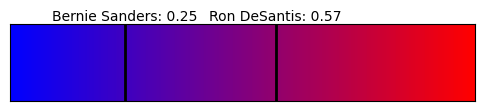

,Bernie Sanders,Ron DeSantis
0,Economic Inequality,Governor DeSantis’s Updates on Hurricane Idalia
1,Workers’ Rights and Union Solidarity,Florida’s Education System and School Choice
2,UAW Labor Movement,Hurricane Idalia Response and Local Support
3,Climate Crisis and Denial,Governor DeSantis Press Conferences in Miami
4,Campaign Finance Reform,Law Enforcement Initiatives and Recruitment in Florida
5,Raising the Federal Minimum Wage,Infrastructure Funding and Economic Development Grants
6,Healthcare as a Human Right,Media Appearances and Discussions on Amendments
7,Political Rally and Voter Mobilization,Governor DeSantis’s Legislative Actions and Announcements
8,Social Security and Tax Fairness,Post-Hurricane Helene Briefings and Media Availability
9,Israel-Palestine Conflict,State Emergency Operations and Hurricane Preparedness Updates


In [150]:
# (Written with assistance from ChatGPT)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from IPython.display import display


def plot_scale(valueD, nameD, valueR, nameR):
    
    fig, ax = plt.subplots(figsize=(6, 1))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    cmap = mcolors.LinearSegmentedColormap.from_list("blue_red", [(0,0,1), (1,0,0)])
    ax.imshow(
        gradient,
        aspect="auto",            
        cmap=cmap,
        extent=[0, 1, -0.5, 0.5],  
        origin="lower"             
    )

    ax.axvline(x=valueD, color='black', linewidth=2)
    ax.axvline(x=valueR, color='black', linewidth=2)

    ax.text(valueD, 0.5, str(nameD + ":" + " " + str(round(average_predictionD,2))),
            rotation_mode='anchor',
            verticalalignment='bottom', 
            horizontalalignment='center',
            color='black',
            fontsize=10)

    ax.text(valueR, 0.5, str(nameR +":" + " " + str(round(average_predictionR,2))),
            rotation_mode='anchor',
            verticalalignment='bottom', 
            horizontalalignment='center',
            color='black',
            fontsize=10)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, 0.5)

    ax.set_yticks([])
    ax.set_xticks([])

    plt.show()

# Make a DataFrame:
nameD = "Bernie Sanders"
nameR = "Ron DeSantis"
data = pd.DataFrame({
    nameD:["Economic Inequality", "Workers’ Rights and Union Solidarity", "UAW Labor Movement", "Climate Crisis and Denial", "Campaign Finance Reform", "Raising the Federal Minimum Wage", "Healthcare as a Human Right", "Political Rally and Voter Mobilization", "Social Security and Tax Fairness", "Israel-Palestine Conflict"]

,
    nameR:  ["Governor DeSantis’s Updates on Hurricane Idalia", "Florida’s Education System and School Choice", "Hurricane Idalia Response and Local Support", "Governor DeSantis Press Conferences in Miami", "Law Enforcement Initiatives and Recruitment in Florida", "Infrastructure Funding and Economic Development Grants", "Media Appearances and Discussions on Amendments", "Governor DeSantis’s Legislative Actions and Announcements", "Post-Hurricane Helene Briefings and Media Availability", "State Emergency Operations and Hurricane Preparedness Updates"]

})

data = data.style.set_caption("Topics Discussed on X")



plot_scale(average_predictionD, "Bernie Sanders", average_predictionR, "Ron DeSantis")

display(data)

